# TM10007 Assignment: Prediction of Tumor Grade in Brain Cancer

Group 4: Kiefer Comassi (4402359), Myrthe van Haaften (4547470), Frédérique Koopman (4470885), Stephanie Stoutjesdijk (4557808)


## Installing and importing functions and packages

In [28]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git
!pip install missingpy

In [31]:
import numpy as np
import pandas as pd
from math import floor
import matplotlib.pyplot as plt
#from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from missingpy import KNNImputer
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn import svm

from brats.load_data import load_data

## Loading and splitting data 

In [34]:
# Load data
data = load_data()

# Splitting feature values and patient labels
FEATURES = data.drop(columns=['label'])
LABELS = data['label']

# Splitting into train and test set
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(FEATURES, LABELS, test_size=0.2, random_state=42)

GBM_TRAIN = X_TRAIN.loc[Y_TRAIN=='GBM']
LGG_TRAIN = X_TRAIN.loc[Y_TRAIN=='LGG']


## Preprocessing

Overview of the NaN's in the dataset

In [37]:
# Determining the number of NaN's
NO_NAN_ROW_TOTAL = X_TRAIN.isnull().sum(axis=1)             # Number of NaN's per patient for GBM and LGG patients
NO_NAN_COL_TOTAL = X_TRAIN.isnull().sum(axis=0)             # Number of NaN's per feature for GBM and LGG patients

GBM_NO_NAN_COL = GBM_TRAIN.isnull().sum(axis=0)             # Number of NaN's per feature for GBM patients
LGG_NO_NAN_COL = LGG_TRAIN.isnull().sum(axis=0)             # Number of NaN's per feature for LGG patients
OVERVIEW_NAN = { 'Total': NO_NAN_COL_TOTAL, 'GBM': GBM_NO_NAN_COL, 'LGG': LGG_NO_NAN_COL } 


Feature selection based on the number of NaN's. Threshold = the maximum number of NaN's in a column.

In [40]:
# Define percentage of patients with no data for a certain feature, above which the feature is discarded
PERC_MISSING_GBM = 5
PERC_MISSING_LGG = 5

# Determining threshold for discarding feature based on above percentage
THRESHOLD_GBM = floor((PERC_MISSING_GBM/100) * len(GBM_TRAIN.index))
THRESHOLD_LGG = floor((PERC_MISSING_LGG/100) * len(LGG_TRAIN.index))

# Initialisation
FEATURES_REMOVED = []

# Append names of features that should be discarded to list

for feature in GBM_NO_NAN_COL[GBM_NO_NAN_COL > THRESHOLD_GBM].index[:]:
    FEATURES_REMOVED.append(feature)

for feature in LGG_NO_NAN_COL[LGG_NO_NAN_COL > THRESHOLD_LGG].index[:]:
    FEATURES_REMOVED.append(feature)

# Remove features from dataset
X_TRAIN_FEAT_SEL = X_TRAIN.drop(columns=[features for features in set(FEATURES_REMOVED)])
X_TEST_FEAT_SEL = X_TEST.drop(columns=[features for features in set(FEATURES_REMOVED)])

# The variables (series) below 'bins' the NaN's:
# - the index column is the amount of NaN's in the dataset 
# - the second column is the amount of features that have this amount of NaN's

#aantal_NAN_GBM = GBM_no_nan_col.value_counts()
#aantal_NAN_LGG = LGG_no_nan_col.value_counts()
#aantal_NAN_total = no_nan_col.value_counts()

##############

# Number of NaN's per patient AFTER removing some features
NO_NAN_ROW_TOTAL_2 = X_TRAIN_FEAT_SEL.isnull().sum(axis=1)      

# Percentage/number of features that a patient is allowed to miss. When above this amount, this patient is removed from the trainingset, because it is missing too many features. 
PERC_MISSING_SAMPLE = 15

# Make the threshold
THRESHOLD_SAMPLE = floor((PERC_MISSING_SAMPLE/100) * len(X_TRAIN_FEAT_SEL.columns))

# Make an empty list, which will be filled with samples that are above the threshold -->
# This is only for consistency, because there is also a FEATURES_REMOVED variable.                              # It is not used anywhere else, so it can be removed if necessary. 
SAMPLES_REMOVED = []   

# Looping over the trainingset to determine which patients are above the threshold, and remove them directly.
print('These samples are removed from trainingset:')
for sample in NO_NAN_ROW_TOTAL_2[NO_NAN_ROW_TOTAL_2 > THRESHOLD_SAMPLE].index[:]:
    print(sample)
    SAMPLES_REMOVED.append(sample)      # This should be removed in combination with the comment before
    X_TRAIN_FEAT_SEL = X_TRAIN_FEAT_SEL.drop(index=sample)
    Y_TRAIN = Y_TRAIN.drop(index=sample)

print(f'{len(X_TRAIN_FEAT_SEL)} samples are left in trainingset')
print(f'{len(X_TRAIN_FEAT_SEL.columns)} features are left in trainingset')

These samples are removed from trainingset:
TCGA-HT-7686


KeyError: "['TCGA-HT-7686'] not found in axis"

kNN imputation of missing values

In [46]:
# Definition of imputers
IMPUTER_GBM = KNNImputer(n_neighbors=5, weights="uniform")
IMPUTER_LGG = KNNImputer(n_neighbors=5, weights="uniform")
IMPUTER_TEST = KNNImputer(n_neighbors=5, weights="uniform")

# Impute GBM train set
X_TRAIN_FEAT_SEL_GBM = X_TRAIN_FEAT_SEL.loc[Y_TRAIN=='GBM']
X_TRAIN_IMP_GBM = IMPUTER_GBM.fit_transform(X_TRAIN_FEAT_SEL_GBM)    

# Impute LGG train set
X_TRAIN_FEAT_SEL_LGG = X_TRAIN_FEAT_SEL.loc[Y_TRAIN=='LGG']
X_TRAIN_IMP_LGG = IMPUTER_LGG.fit_transform(X_TRAIN_FEAT_SEL_LGG)    

# Merge imputed GBM and LGG arrays
X_TRAIN_IMP_TOT = np.concatenate((X_TRAIN_IMP_GBM, X_TRAIN_IMP_LGG))
                                
#LGG_IMPUTED[:] = ARRAY_IMP_LGG                                                      # Overwrite original values with imputed values in dataframe
#LGG_IMPUTED['label'] = 'LGG'                                                        # Add column containing label

# Impute test set 
IMPUTER_TEST.fit(X_TRAIN_IMP_TOT)
X_TEST_IMP = IMPUTER_TEST.transform(X_TEST_FEAT_SEL)

Evaluation of outliers

In [ ]:
# Calculate mean and standard deviation per feature based on training data
MEAN = X_TRAIN_IMP_TOT.mean(axis=0)
STD = X_TRAIN_IMP_TOT.std(axis=0)

# Evaluate per patient each feature
no_outliers = 0
for patient in X_TRAIN_IMP_TOT:
    feat_out = 0
    for feature, mu, std in zip(patient, MEAN, STD):
        outlier = ((feature>mu+3*std) | (feature<mu-3*std))
        feat_out += outlier
    if feat_out > 30:
        no_outliers += 1

Scaling of data

In [ ]:
SCALER = RobustScaler()
SCALER.fit(X_TRAIN_IMP_TOT)
X_TRAIN_SCAL = SCALER.transform(X_TRAIN_IMP_TOT)
X_TEST_SCAL = SCALER.transform(X_TEST_IMP)


Feature selection

Optimal number of features : 1


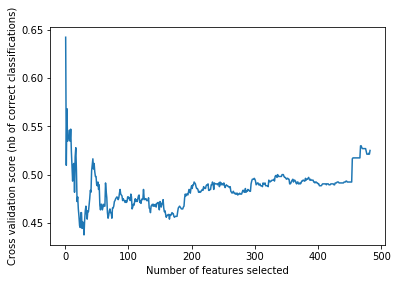

In [55]:
svc = svm.SVC(kernel="linear")

# classifications
rfecv = RFECV(
    estimator=svc, step=1, 
    cv=StratifiedKFold(4),
    scoring='roc_auc')
rfecv.fit(X_TRAIN_SCAL, Y_TRAIN)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()